# Learning Dynamics from Pixels: Lagrangian Neural Networks with Autoencoders
We know we can learn lagrangian dynamics from the data and/or coordinated we feed in. But can we do so directly from images? We will try to do exactly that in this notebook.

The idea is to train the Lagrangian network not on the physical coordinates of the system, rather the latent coordinates learnt by an autoencoder. To do this, we will construct a neural network such that we can encode from 'pixels' to 2d latent cordinates and then learn the dynamics on this cordinate system. We can then transform the evolved dynamic back into pixel dimension

In [2]:
import numpy as np
import gymnasium as gym
import scipy, scipy.misc
import pickle
from PIL import Image
from tqdm.notebook import tqdm
import os
import imageio, shutil
from IPython import display
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageSequence, ImageFont
import io
import torch.nn.functional as F
from functools import partial
from torch.autograd.functional import jacobian, hessian


In [3]:
# device prioritizing: CUDA, then MPS, then CPU

# device = torch.device(
#     "cuda" if torch.cuda.is_available() 
#     else "mps" if torch.backends.mps.is_available() 
#     else "cpu"
# )

# unfortunately, MPS doesn't work with some of the functions we use here
# so we'll just use cpu. but its not too slow, so its fine ;)
device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


# The Dataset
We use the [pendulum data from gymnasium library](https://gymnasium.farama.org/environments/classic_control/pendulum/). The library provides us a way to render images to run a simulation of pendulum. A single frame of pendulum looks like this

 <img src = './gym_pendulum.png' width = "400" height = "400">


Since the image is quite rich, we will preprocess it by making it something manageable. We remove the colours, crop and resize and 28*28 images

In [4]:
def get_theta(obs):
    # The observation is a ndarray with shape (3,) representing the x-y coordinates of the pendulum’s free end and its angular velocity.
    '''Transforms coordinate basis from the defaults of the gym pendulum env.'''
    if type(obs) == tuple:
        obs = obs[0]
    
    theta = np.arctan2(obs[0], -obs[1])
    theta = theta + np.pi/2
    theta = theta + 2*np.pi if theta < -np.pi else theta
    theta = theta - 2*np.pi if theta > np.pi else theta
    return theta

def preproc(X, side, px = 120):
    '''Crops, downsamples, desaturates, etc. the rgb pendulum observation.'''
    X = X[...,0][2*px:-px,px:-px] - X[...,1][2*px:-px,px:-px]
    # might need to adjust the cropping for the other pendulum envs
    # X = X[...,0][440:-220,330:-330] - X[...,1][440:-220,330:-330]
    # X = X[..., 0] - X[..., 1]  
    img = Image.fromarray(X.astype(np.uint8))  
    img_resized = img.resize((int(side), side))  
    return np.array(img_resized) / 255  # Convert back to NumPy array

In [5]:
def sample_gym(seed=0, timesteps=103, trials=20, side=28, min_angle=0., max_angle=np.pi/6, 
              env_name='Pendulum-v1'):
    """Samples a dataset from a gym environment.
    
        trials: number of trials to sample
        timesteps: number of timesteps per trial
        side: side length of the square image
        min_angle: minimum angle of the pendulum to start recording
        max_angle: maximum angle of the pendulum to start recording
    """

    gym_settings = locals()
    env = gym.make(env_name, render_mode='rgb_array')

    canonical_coords, frames = [], []
    for step in tqdm(range(trials*timesteps), desc="Creating dataset"):

        if step % timesteps == 0:
            angle_ok = False

            while not angle_ok:
                obs = env.reset()
                theta_init = np.abs(get_theta(obs))
                if theta_init > min_angle and theta_init < max_angle:
                    angle_ok = True
      
        frames.append(preproc(env.render(), side))
        obs, _, _, _, _ = env.step([0.])
        theta, dtheta = get_theta(obs), obs[-1]
        canonical_coords.append( np.array([theta, dtheta]) )
    
    canonical_coords = np.stack(canonical_coords).reshape(trials*timesteps, -1)
    frames = np.stack(frames).reshape(trials*timesteps, -1)
    return canonical_coords, frames, gym_settings

We need to concatenate each frame with its successor so that the input to our model can be a tensor of shape batch x 28 x 28 x 2. We need two frames so that velocity would be observable from the input. Without the ability to observe velocity, an autoencoder without recurrence would be unable to ascertain the system’s full state space.

In [6]:
def make_gym_dataset(test_split=0.2, **kwargs):
    '''Constructs a dataset of observations from an OpenAI Gym env'''
    canonical_coords, frames, gym_settings = sample_gym(**kwargs)
    coords, dcoords = [], [] # position and velocity data (canonical coordinates)
    pixels, dpixels = [], [] # position and velocity data (pixel space)
    next_pixels, next_dpixels = [], [] # (pixel space measurements, 1 timestep in future)

    trials = gym_settings['trials']
    for cc, pix in zip(np.split(canonical_coords, trials), np.split(frames, trials)):
        # calculate cc offsets
        cc = cc[1:]
        dcc = cc[1:] - cc[:-1]
        cc = cc[1:]

        # concat adjacent frames to get velocity information
        # now the pixel arrays have same information as canonical coords
        # ...but in a different (highly nonlinear) basis
        p = np.concatenate([pix[:-1], pix[1:]], axis=-1)
        
        dp = p[1:] - p[:-1]
        p = p[1:]

        # calculate the same quantities, one timestep in the future
        next_p, next_dp = p[1:], dp[1:]
        p, dp = p[:-1], dp[:-1]
        cc, dcc = cc[:-1], dcc[:-1]

        # append to lists
        coords.append(cc) ; dcoords.append(dcc)
        pixels.append(p) ; dpixels.append(dp)
        next_pixels.append(next_p) ; next_dpixels.append(next_dp)

    # concatenate across trials
    data = {'coords': coords, 'dcoords': dcoords,
            'pixels': pixels, 'dpixels': dpixels, 
            'next_pixels': next_pixels, 'next_dpixels': next_dpixels}
    data = {k: np.concatenate(v) for k, v in data.items()}

    # make a train/test split
    split_ix = int(data['coords'].shape[0]* test_split)
    split_data = {}
    for k, v in data.items():
      split_data[k], split_data['test_' + k] = v[split_ix:], v[:split_ix]
    data = split_data

    gym_settings['timesteps'] -= 3 # from all the offsets computed above
    data['meta'] = gym_settings

    return data

In [7]:
def get_dataset(experiment_name, filename, **kwargs):
  '''Returns a dataset bult on top of OpenAI Gym observations. Also constructs
  the dataset if no saved version is available.'''
  
  if experiment_name == "pendulum":
    env_name = "Pendulum-v1"

  path = f'./{filename}.pkl'

  try:
      with open(path, 'rb') as f:
        data = pickle.load(f)
        print("Successfully loaded data from {}".format(path))
  except:
      print("Had a problem loading data from {}. Rebuilding dataset...".format(path))
      data = make_gym_dataset(**kwargs)
      with open(path, 'wb') as f:
        pickle.dump(data, f)

  return data

In [8]:
data = get_dataset('pendulum', 'pendulum_data_gym')

Had a problem loading data from ./pendulum_data_gym.pkl. Rebuilding dataset...


Creating dataset:   0%|          | 0/2060 [00:00<?, ?it/s]

/var/folders/qn/xqf2q5g92lgd4j6z0bq50vyh0000gp/T/ipykernel_53361/31721491.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(temp_dir, f)) for f in sorted(os.listdir(temp_dir)) if f.endswith('.png')]


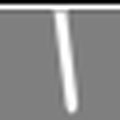

In [9]:
DPI = 300
num_frames = 400
save_dir = './vis/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def make_gif(frames, save_dir, name='pendulum', duration=1e-1, pixels=None, divider=0):
    '''Given a three-dimensional array [frames, height, width], make a gif and save it.'''
    temp_dir = './_temp'
    os.makedirs(temp_dir, exist_ok=True)  # Create temp dir if it doesn't exist
    
    for i, frame in enumerate(frames):
        im = (np.clip(frame, -0.5, 0.5) + 0.5) * 255  # Normalize to [0,255]
        im = im.astype(np.uint8)
        im[divider, :] = 0
        im[divider + 1, :] = 255

        if pixels is not None:
            im = np.array(Image.fromarray(im).resize(pixels, Image.LANCZOS))  # Resize using PIL
        
        imageio.imwrite(os.path.join(temp_dir, f'f_{i:04d}.png'), im)  # Save frame

    images = [imageio.imread(os.path.join(temp_dir, f)) for f in sorted(os.listdir(temp_dir)) if f.endswith('.png')]
    
    save_path = os.path.join(save_dir, f'{name}.gif')
    imageio.mimsave(save_path, images, duration=duration)  # Save GIF

    shutil.rmtree(temp_dir)  # Cleanup temporary files
    return save_path


side = data['meta']['side'] 
trials = data['meta']['trials']
timesteps = data['meta']['timesteps']

frames = data['pixels'][:,:side**2].reshape(-1, side, side)[:num_frames]
name = 'pendulum'
gifname = make_gif(frames, save_dir, name=name, duration=1e-1, pixels=[120,120])

display.Image(filename=gifname, width=200)

# Model Architecture
The model consists of 2 main componenets: The Autoeconder and the LNN. The autoencoder takes in 28*28*2 images, encodes into 2 latent dimensions and decodes back into original dimensions. Both the encoder and decoder consists of four fully-connected layers with relu activations and residual connections. The LNN is modelled by 3 fully connected layers with softplus activation.

During the forward pass, we feed a pair of images to the network which is encoded into two latent dimensions, $z_o$ and $z_1$. Herein, we use LNN to predict the time derivative i.e. $\dot z_o$ and $\dot z_1$. The forward pass of LNN implements: 
$$
\ddot q = (\nabla_{\dot q}\nabla_{\dot q}^{\top}{L})^{-1}[\nabla_q {L} - (\nabla_{q}\nabla_{\dot q}^{\top}{L})\dot q] 
$$

## Loss function
The loss consists of 3 terms: the first being a classic autoencoder loss (L2 loss over pixels), the second being the LNN loss,  and the third being an auxiliary loss on the autoencoder’s latent space to make the latent cordinates evolve analogous to $\theta$ and $\dot \theta$ 

In [10]:
class MLPAutoencoder(torch.nn.Module):
  '''Vanilla autoencoder with 4 fully connected layers.'''
  def __init__(self, input_dim, hidden_dim, latent_dim, device=device):
    super(MLPAutoencoder, self).__init__()
    self.device = device
    
    self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
    self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.linear3 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.linear4 = torch.nn.Linear(hidden_dim, latent_dim)

    self.linear5 = torch.nn.Linear(latent_dim, hidden_dim)
    self.linear6 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.linear7 = torch.nn.Linear(hidden_dim, hidden_dim)
    self.linear8 = torch.nn.Linear(hidden_dim, input_dim)
    
    for l in [self.linear1, self.linear2, self.linear3, self.linear4, \
              self.linear5, self.linear6, self.linear7, self.linear8]:
      torch.nn.init.orthogonal_(l.weight)  

    self.nonlinearity =torch.relu

  def encode(self, x):
    x = x.to(self.device)
    h = self.nonlinearity( self.linear1(x) )
    h = h + self.nonlinearity( self.linear2(h) )
    h = h + self.nonlinearity( self.linear3(h) )
    return self.linear4(h)

  def decode(self, z):
    z = z.to(self.device)
    h = self.nonlinearity( self.linear5(z) )
    h = h + self.nonlinearity( self.linear6(h) )
    h = h + self.nonlinearity( self.linear7(h) )
    return self.linear8(h)

  def forward(self, x):
    x = x.to(self.device)
    z = self.encode(x)
    x_hat = self.decode(z)
    return x_hat



class LNN(torch.nn.Module):
    def __init__(self, input_size, device=device):  
        super(LNN, self).__init__()
        self.device = device 
        self.fc1 = torch.nn.Linear(input_size, 128).to(self.device) 
        self.fc2 = torch.nn.Linear(128, 128).to(self.device) 
        self.fc3 = torch.nn.Linear(128, 1).to(self.device)
    
    def lagrangian(self, x):
        
        x = F.softplus(self.fc1(x))
        x = F.softplus(self.fc2(x))
        x = self.fc3(x)
        
        return x 
      
    # the core of LNN
    def forward(self, x):
        x = x.to(self.device)
        n = x.shape[1]//2
        xv = torch.autograd.Variable(x, requires_grad=True)
        xv_tup = tuple([xi for xi in x]) 

        #xv_tup is tuple of "states" in various time frames.
        tqt = xv[:, n:]

        jacpar = partial(jacobian,  self.lagrangian, create_graph=True)
        hesspar = partial(hessian,  self.lagrangian, create_graph=True)

        A = tuple(map(hesspar, xv_tup))
        B = tuple(map(jacpar, xv_tup))        
        multi = lambda Ai, Bi, tqti, n:  torch.pinverse(Ai[n:, n:]) @ (Bi[0][:n] - Ai[n:, :n] @ tqti) 
        multi_par = partial(multi, n=n)

        tqtt_tup = tuple(map(multi_par, A, B, tqt))
        tqtt = torch.cat([tqtti[None] for tqtti in tqtt_tup])

        xt = torch.cat([tqt, tqtt], axis=1)
        if self.training:
            xt.retain_grad()
        return xt
      
class PixelLNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, device=None):
        super(PixelLNN, self).__init__()
        self.device = device
        self.autoencoder = MLPAutoencoder(input_dim, hidden_dim, latent_dim).to(device)
        self.lnn = LNN(latent_dim).to(self.device)

    def encode(self, x):
        return self.autoencoder.encode(x)

    def decode(self, z):
        return self.autoencoder.decode(z)

    def time_derivative(self, z):
        return self.lnn(z)
    
    def forward(self, x):
        x = x.to(self.device)
        z = self.encode(x)
        z_next = z + self.time_derivative(z)
        return self.decode(z_next)


In [11]:

losses = []
def pixelhnn_loss(x, x_next, model, return_components=False,):
  
  # encode pixel space -> latent dimension
  x, x_next = x.to(model.device), x_next.to(model.device)
  z = model.encode(x)
  z_next = model.encode(x_next)

  # autoencoder loss
  x_hat = model.decode(z)
  ae_loss = ((x - x_hat)**2).mean(1)

  # lnn loss
  z_hat_next = z + model.time_derivative(z) # replace with rk4
  lnn_loss = ((z_next - z_hat_next)**2).mean(1)

  # canonical coordinate loss
  # -> makes latent space look like (x, v) coordinates
  theta, omega = z.split(1,1)
  theta_next, _ = z_next.split(1,1)
  cc_loss = ((omega-(theta_next - theta))**2).mean(1)

  loss = ae_loss + cc_loss + 0.1*lnn_loss
  losses.append([ae_loss.mean().item(), cc_loss.mean().item(), lnn_loss.mean().item()])
  if return_components:
        return loss.mean(), (ae_loss.mean(), cc_loss.mean(), lnn_loss.mean())
  return loss.mean()


In [12]:
x = torch.tensor( data['pixels'], dtype=torch.float32)
test_x = torch.tensor( data['test_pixels'], dtype=torch.float32)
next_x = torch.tensor( data['next_pixels'], dtype=torch.float32)
test_next_x = torch.tensor( data['test_next_pixels'], dtype=torch.float32)

#shapes
print(x.shape, test_x.shape, next_x.shape, test_next_x.shape)

torch.Size([1600, 1568]) torch.Size([400, 1568]) torch.Size([1600, 1568]) torch.Size([400, 1568])


In [13]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

input_dim = 2*28**2
hidden_dim = 200
latent_dim = 2
learn_rate = 1e-3

model = PixelLNN(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
    device=device 
)

optim = torch.optim.Adam(model.parameters(), learn_rate, weight_decay=1e-5)


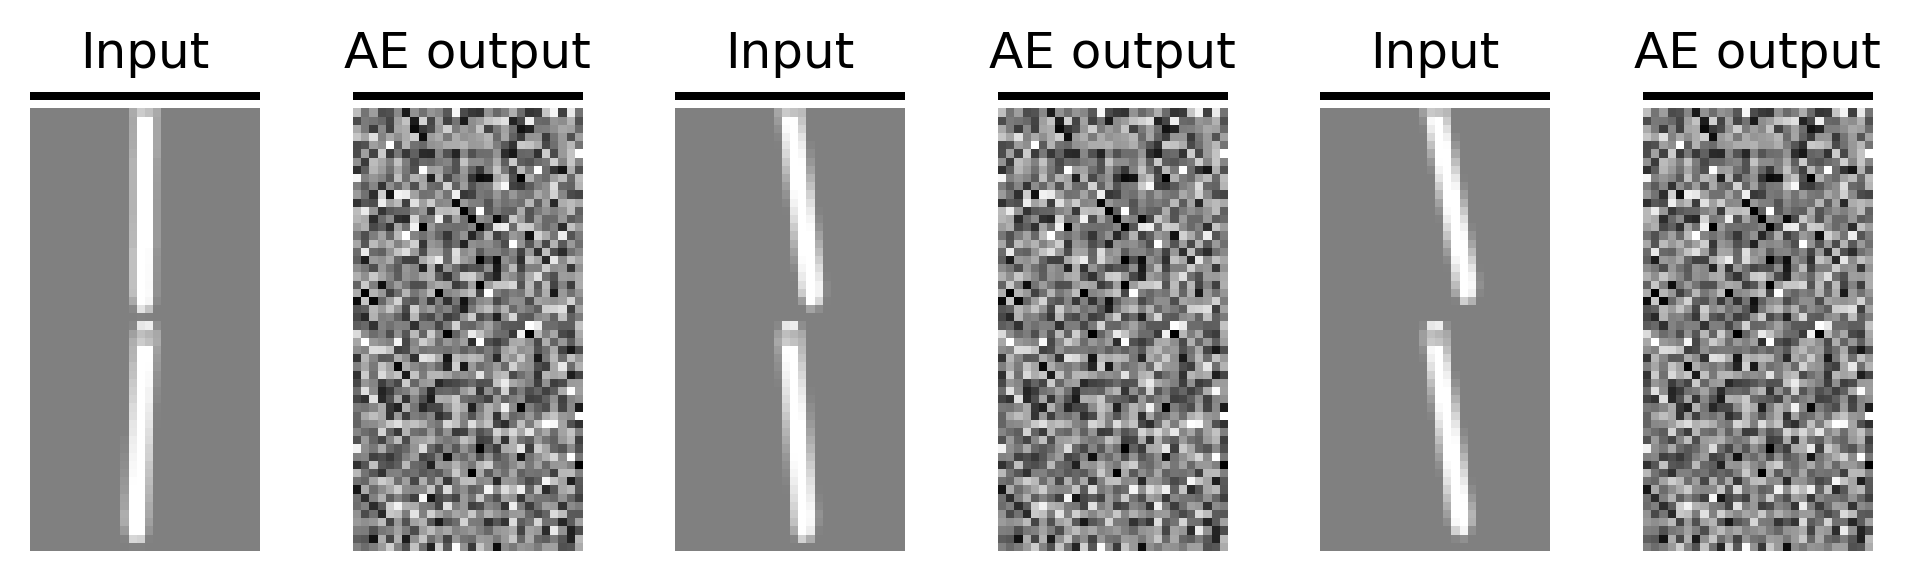

In [14]:
def visualise_autoencoder(rows = 1, cols = 3, device=device, filename = None):
  fig = plt.figure(figsize=[1.1*2*cols, 2*rows], dpi=DPI)

  x = torch.tensor( data['pixels'], dtype=torch.float32).to(device)
  x_next = torch.tensor( data['next_pixels'], dtype=torch.float32).to(device)

  ixs = torch.randperm(x.shape[0])[:2*rows*cols]
  bx, bx_next = x[ixs], x_next[ixs]
  bx_hat_next = model.autoencoder(bx_next)
  bx_next = bx_next.cpu()
  bx_hat_next = bx_hat_next.cpu()

  for r in range(rows):
    for c in range(cols):
      ix = r*2*cols + 2*c
      
      plt.subplot(rows, 2*cols, ix + 1)
      im = bx_next[ix].detach().numpy().reshape(-1,side)
      im = (im.clip(-.5,.5) + .5)
      im[0,:] = 0 ; im[1,:] = 1
      plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("Input")
      
      
      plt.subplot(rows, 2*cols, ix + 2)
      im = bx_hat_next[ix].detach().numpy().reshape(-1,side)
      im = (im.clip(-.5,.5) + .5)
      im[0,:] = 0 ; im[1,:] = 1
      plt.imshow(im, cmap='gray') ; plt.axis('off') ; plt.title("AE output")
      
  plt.tight_layout() 
  plt.show()
  if filename:
    plt.savefig(filename, bbox_inches='tight')
    plt.close()
visualise_autoencoder()

Training_:   0%|          | 0/2000 [00:00<?, ?it/s]

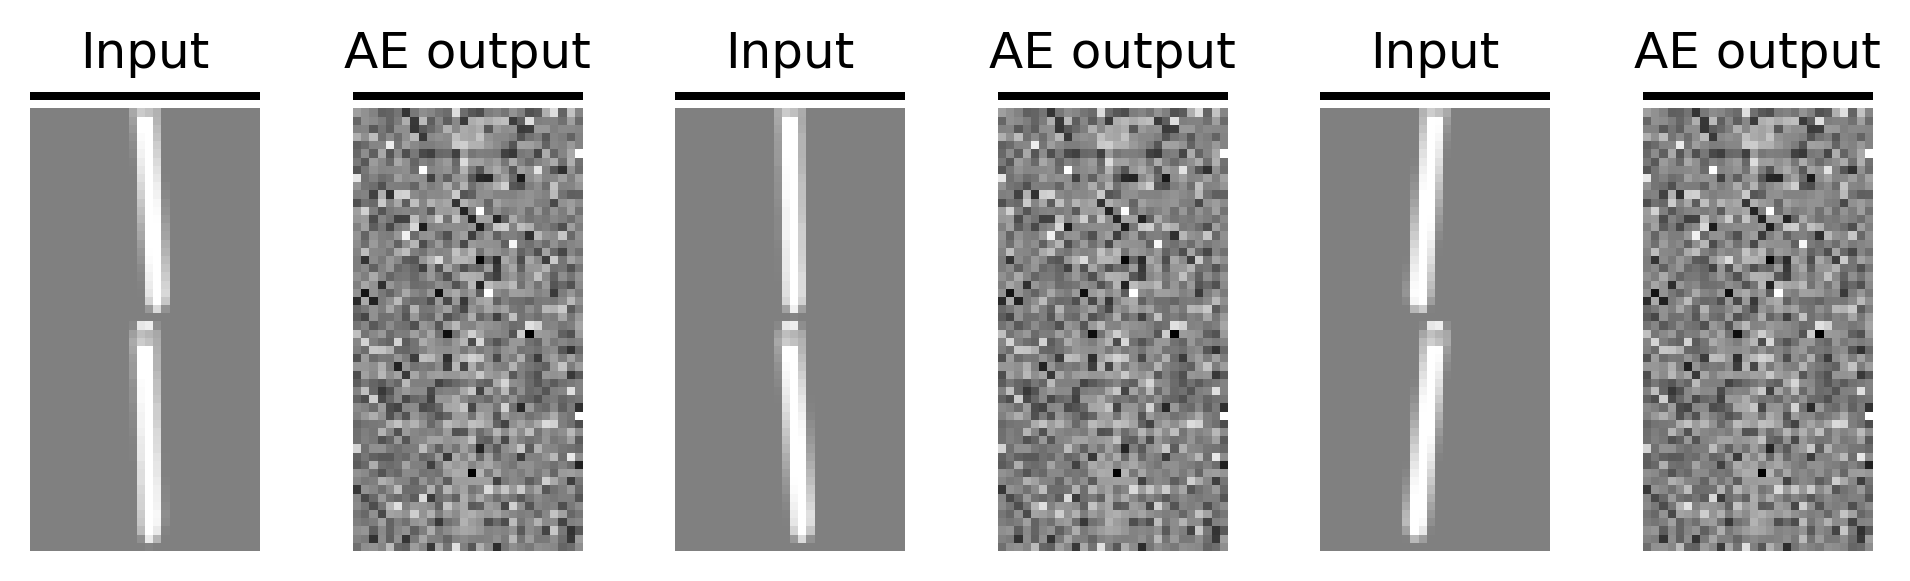

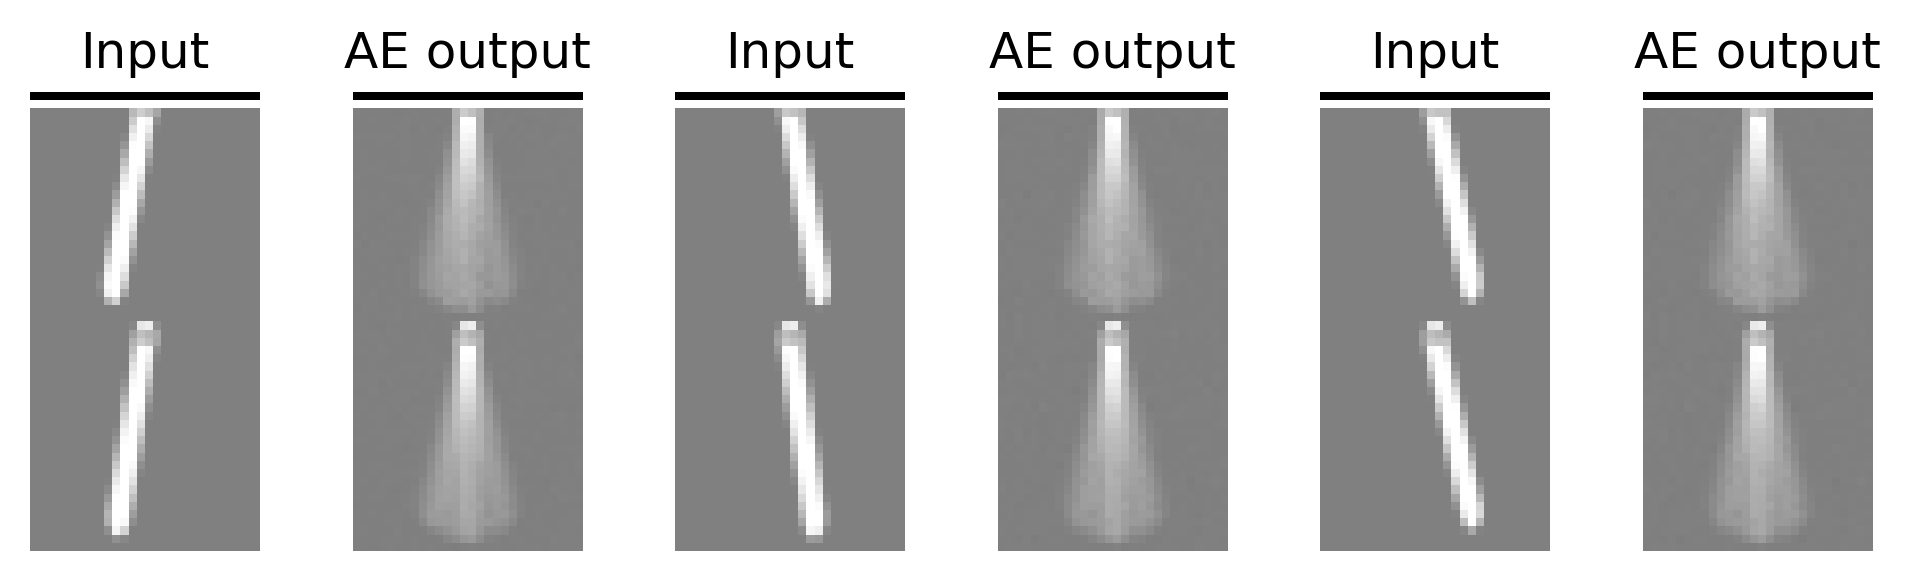

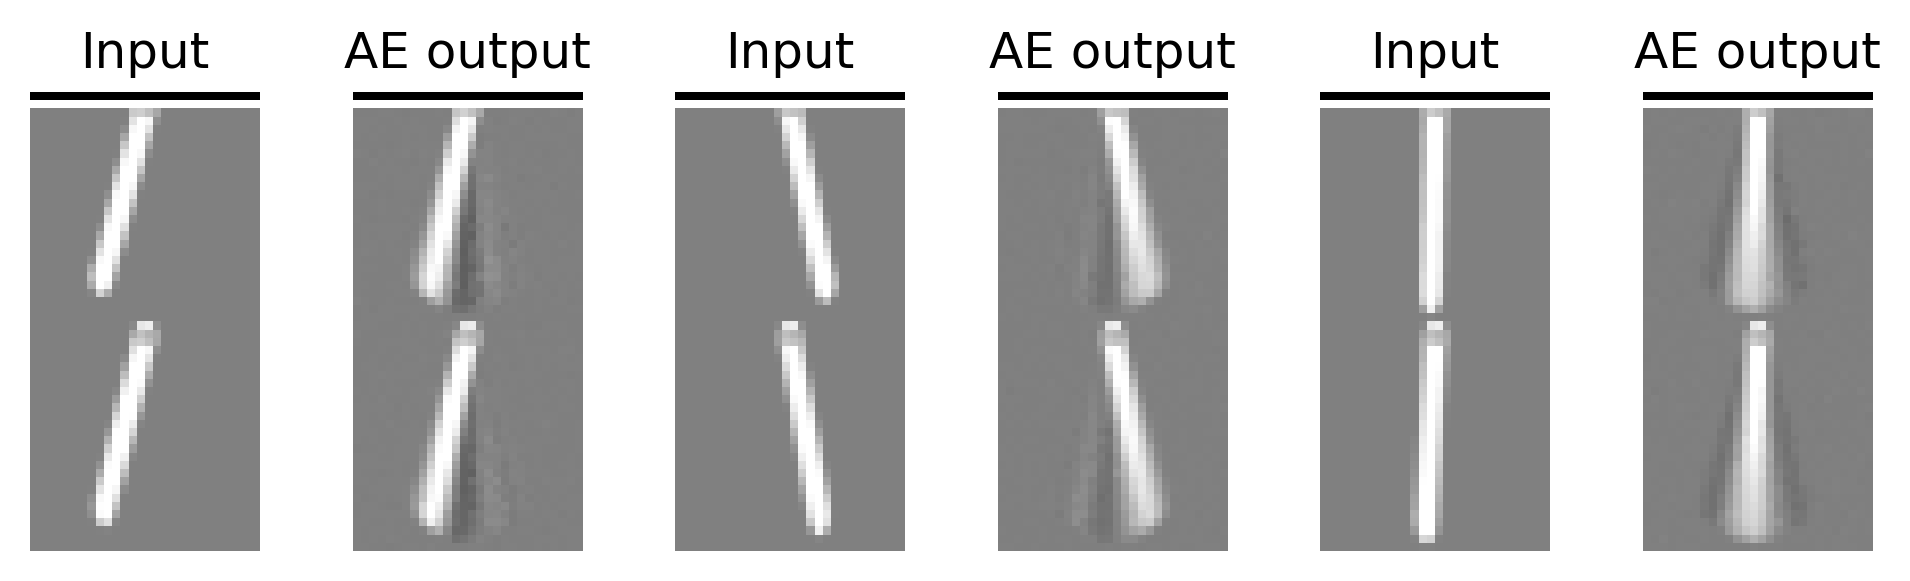

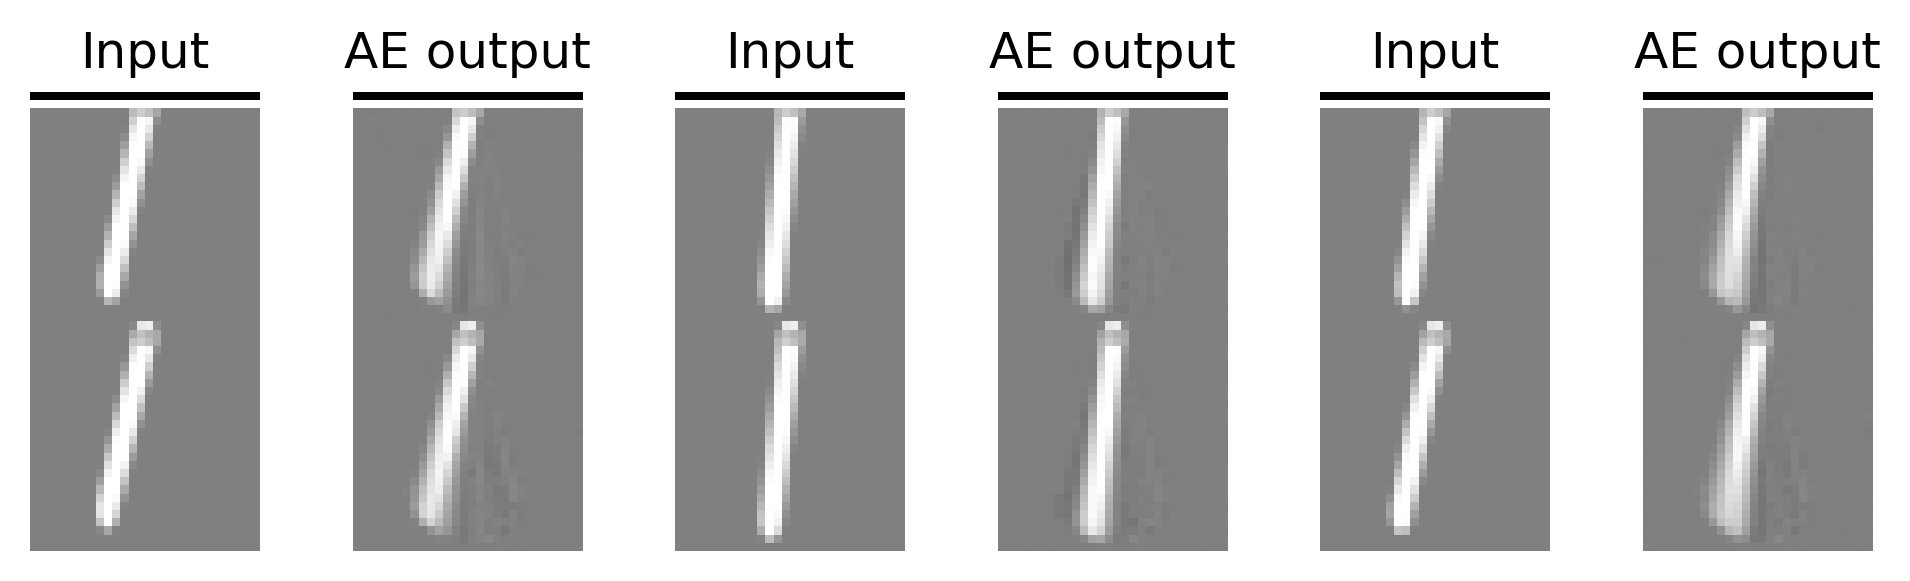

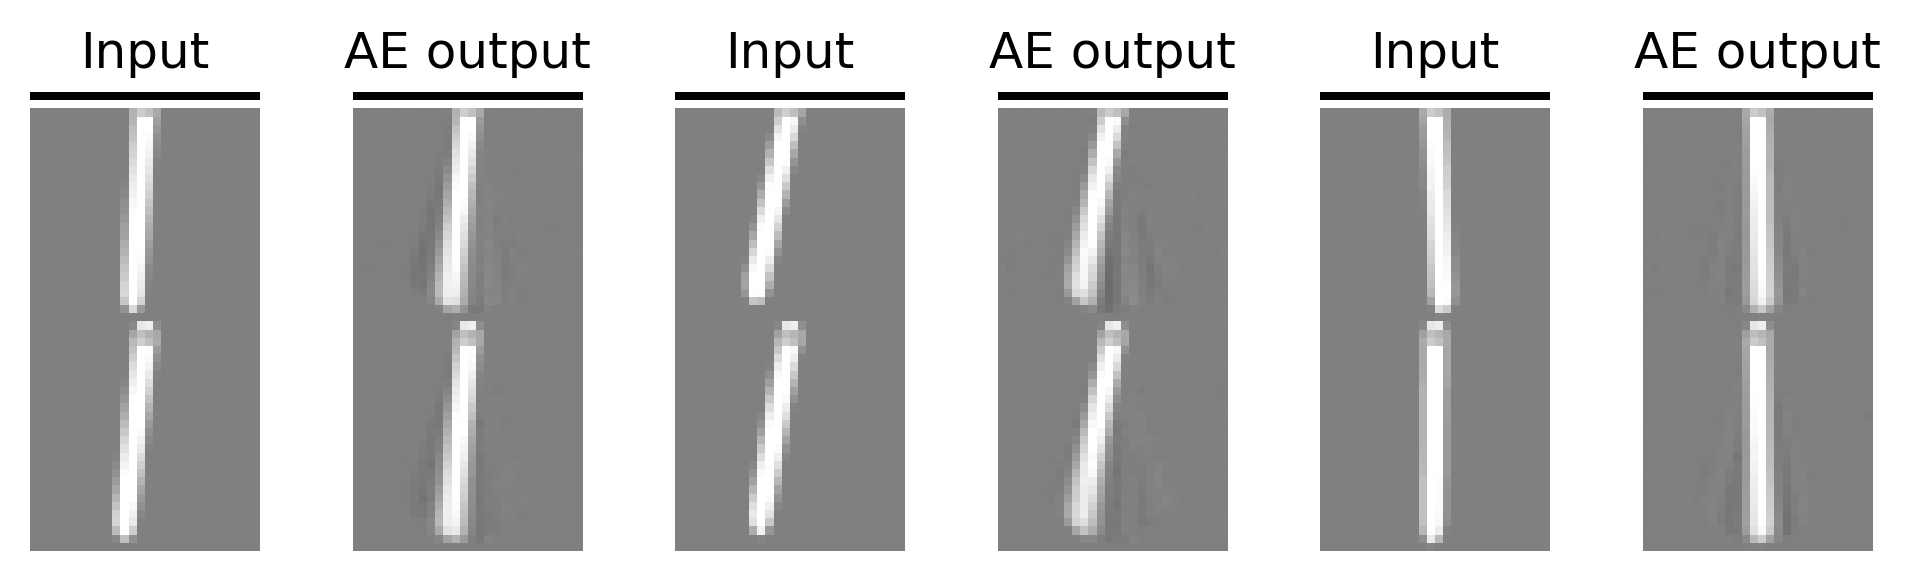

PixelLNN(
  (autoencoder): MLPAutoencoder(
    (linear1): Linear(in_features=1568, out_features=200, bias=True)
    (linear2): Linear(in_features=200, out_features=200, bias=True)
    (linear3): Linear(in_features=200, out_features=200, bias=True)
    (linear4): Linear(in_features=200, out_features=2, bias=True)
    (linear5): Linear(in_features=2, out_features=200, bias=True)
    (linear6): Linear(in_features=200, out_features=200, bias=True)
    (linear7): Linear(in_features=200, out_features=200, bias=True)
    (linear8): Linear(in_features=200, out_features=1568, bias=True)
  )
  (lnn): LNN(
    (fc1): Linear(in_features=2, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [15]:
total_steps = 2000
print_every = 400
batch_size = 64
stats = {'train_loss': [], 'test_loss': []}
#move everything to device
model = model.to(device)
x = x.to(device)
test_x = test_x.to(device)
next_x = next_x.to(device)
test_next_x = test_next_x.to(device)


model.train()
pbar = tqdm(range(total_steps), desc=f"Training_")
for step in pbar:
    # train step
    ixs = torch.randperm(x.shape[0])[:batch_size]
    
    loss = pixelhnn_loss(x[ixs], next_x[ixs], model)
    optim.zero_grad()
    loss.backward() 
    optim.step() 


    stats['train_loss'].append(loss.item())
    pbar.set_postfix({'Train Loss': loss.item()})
    if step % print_every == 0:
        model.eval()
        # run validation
        test_ixs = torch.randperm(test_x.shape[0])[:batch_size]
        with torch.no_grad():
            test_loss = pixelhnn_loss(test_x[test_ixs], test_next_x[test_ixs], model)
        stats['test_loss'].append(test_loss.item())

    # print("step {}, train_loss {:.4e}, test_loss {:.4e}"
    #   .format(step, loss.item(), test_loss.item()))
        visualise_autoencoder(1, 3, filename=f'./vis/ae_fnl_{step}.png')
        model.train()
model.eval()
# with open(f'./models/params_pixellnn_fnl.pkl', 'wb') as f:
#     pickle.dump(model.state_dict(), f)


In [35]:
# save model
model_dir = './models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
with open(f'{model_dir}/params_pixellnn.pkl', 'wb') as f:
     pickle.dump(model.state_dict(), f)

# How good is the autoencoder?

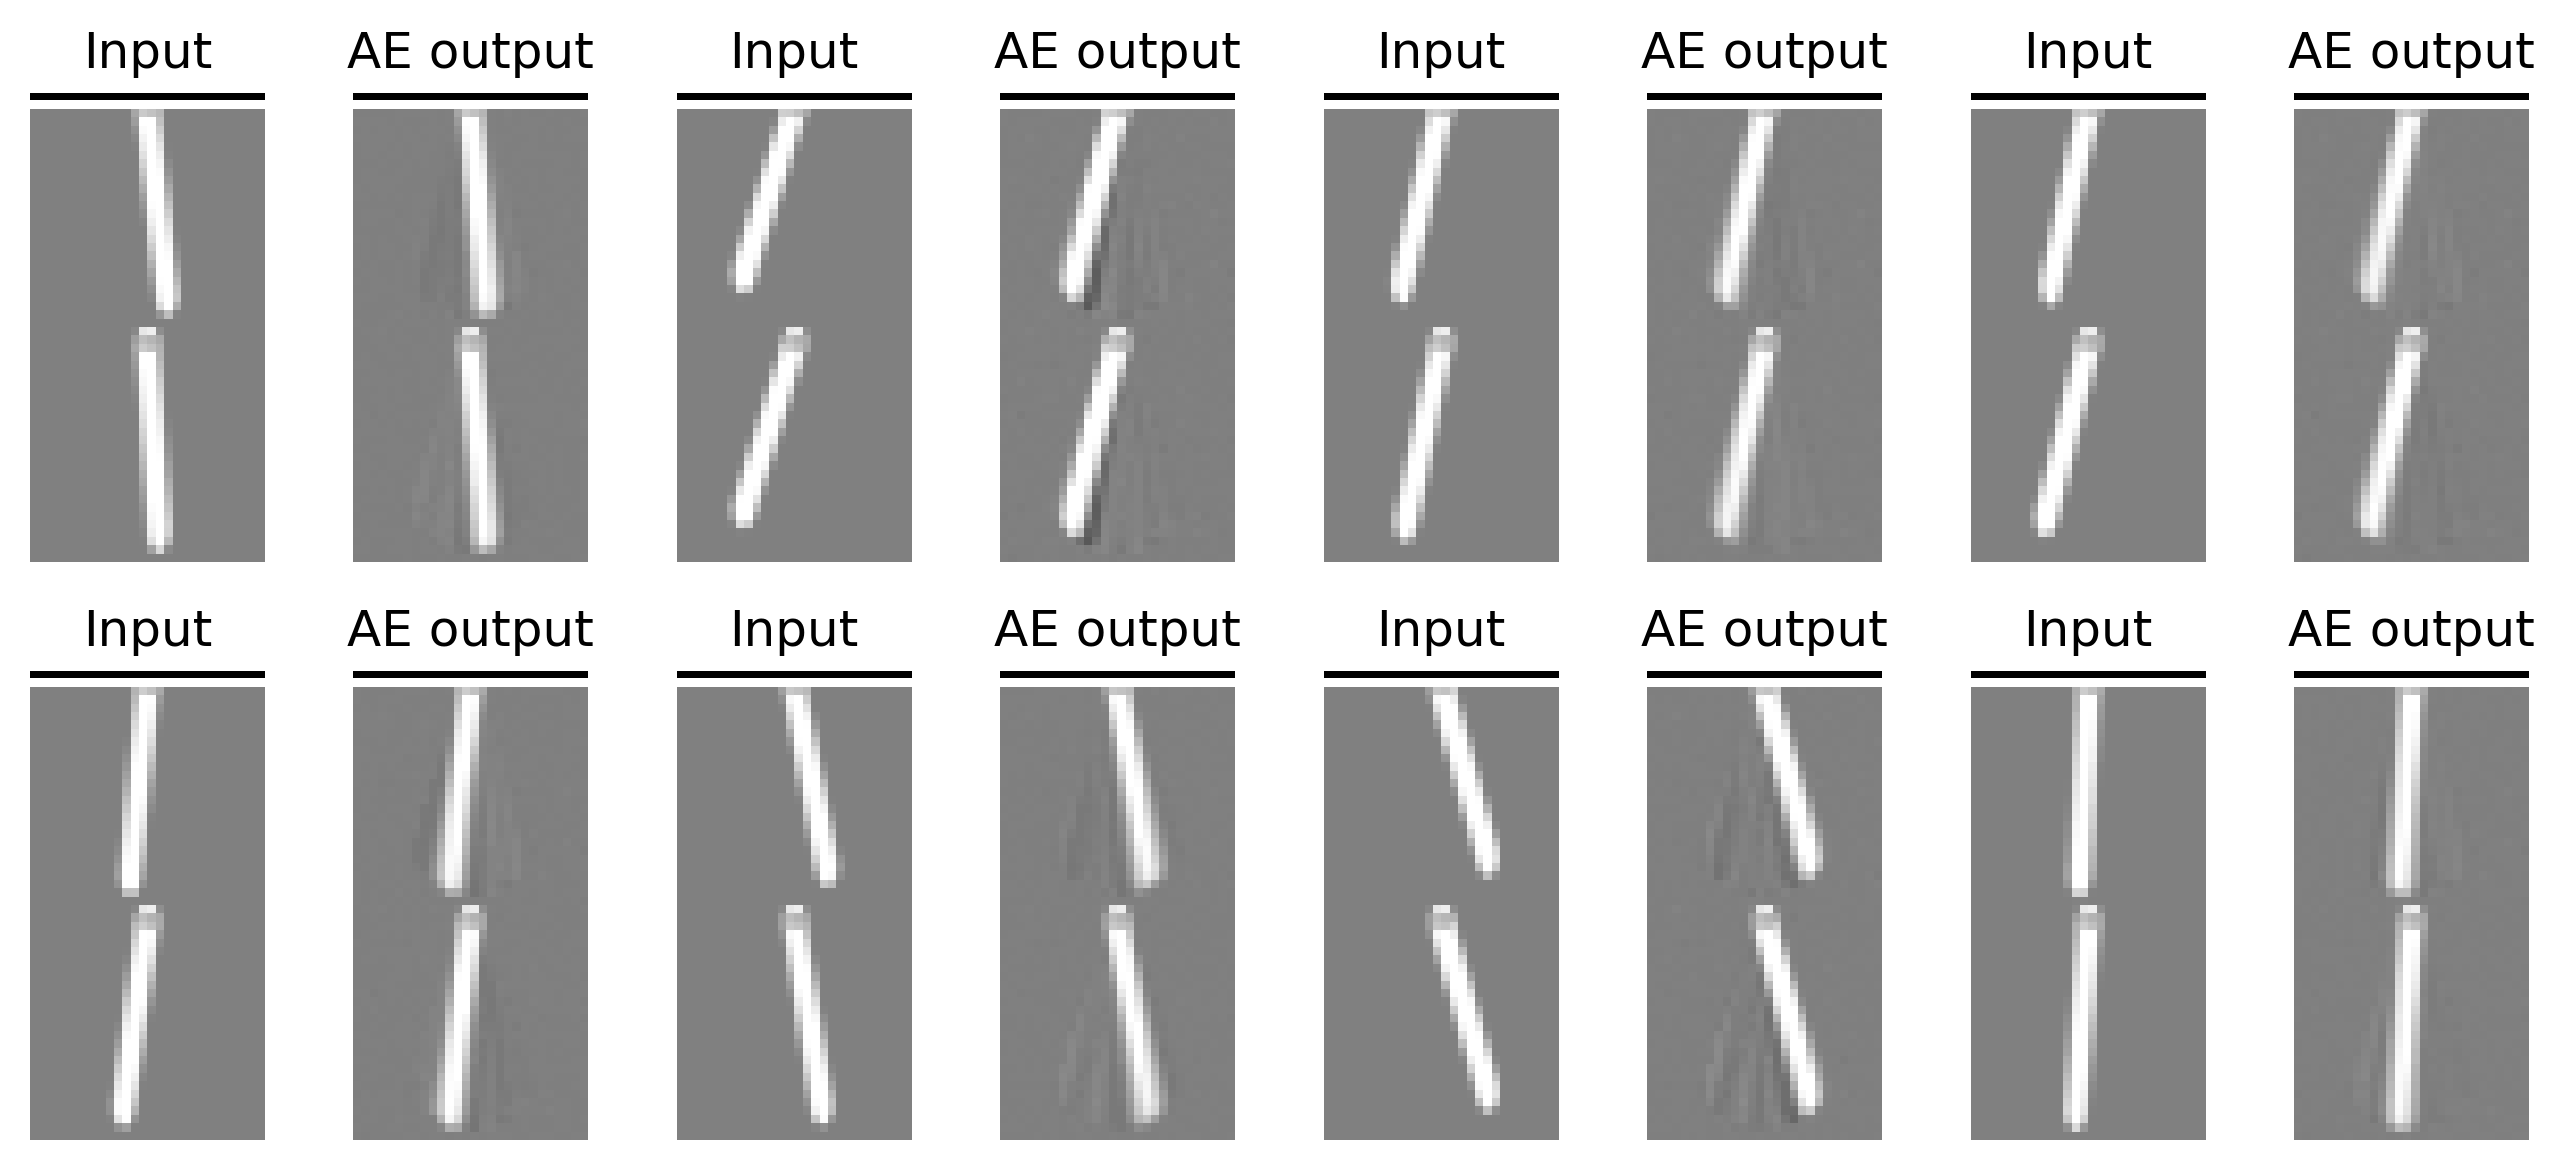

In [16]:
visualise_autoencoder(2, 4)


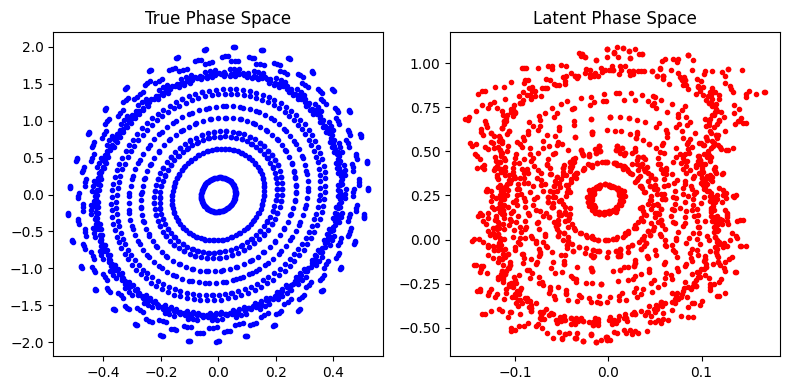

In [19]:
latents = model.encode(x).detach().numpy()
fig = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(data['coords'][:,0], data['coords'][:,1], 'b.')
plt.title('True Phase Space')

plt.subplot(122)
plt.plot(-latents[:,1], latents[:,0], 'r.')
plt.title('Latent Phase Space')
plt.tight_layout()

# Visualisation of Dynamics

we can now sample a new test point from the dataset and try to evaluate how it evolves compared to the ground truth

Creating dataset:   0%|          | 0/203 [00:00<?, ?it/s]

/var/folders/qn/xqf2q5g92lgd4j6z0bq50vyh0000gp/T/ipykernel_52395/31721491.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(temp_dir, f)) for f in sorted(os.listdir(temp_dir)) if f.endswith('.png')]


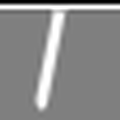

In [26]:
# get a new test data/trial
num_frames = 200
test_data = make_gym_dataset(seed=1, timesteps=num_frames+3, trials=1, test_split=0,
                             max_angle=np.pi/8, min_angle=np.pi/10)


side = test_data['meta']['side']

real_pixel_traj = test_data['pixels'][:,:side**2].reshape(-1, side, side)[:num_frames]
name = 'pendulum-truth'
gifname = make_gif(real_pixel_traj, save_dir, name=name, duration=1e-1, pixels=[120,120])

display.Image(filename=gifname, width=200)

Given the first frame, we can now encode it to get the latent coordinates, then integrate in the latent space to get the trajectory of the pendulum in the latent space. Thereafter, we can decode it back to the original space

In [27]:
import scipy, scipy.misc, scipy.integrate
solve_ivp = scipy.integrate.solve_ivp
def integrate_model(model, t_span, y0, fun=None, **kwargs):
  def default_fun(t, np_x):
      x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
      x = x.view(1, np.size(np_x)) # batch size of 1
      dx = model.time_derivative(x).data.numpy().reshape(-1)
      return dx
  fun = default_fun if fun is None else fun
  return solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

# get initial values of latents
x0 = torch.tensor( test_data['pixels'][0:1], dtype=torch.float32)
lnn_y0 = model.encode(x0).detach().numpy().squeeze()

# integrator settings
t_span = [0, 0.98*num_frames]
point_density = num_frames / t_span[-1]
t_eval = np.linspace(t_span[0], t_span[1], num_frames)

# integrate models
# Here we don't compute t_eval[0] because it's the initial state of the system
#   and thus is already known.
lnn_traj = integrate_model(model, t_span, lnn_y0, t_eval=t_eval[1:])

/var/folders/qn/xqf2q5g92lgd4j6z0bq50vyh0000gp/T/ipykernel_52395/1585732447.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


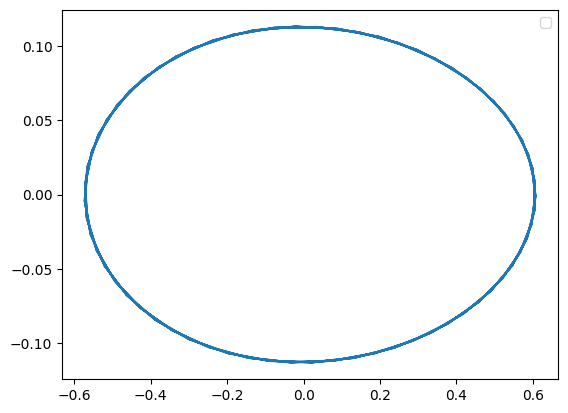

In [28]:
plt.plot(lnn_traj['y'][0], lnn_traj['y'][1],'-')
plt.legend(loc='upper right')
plt.show()

As expected, the trajectory is almost circular! We can now map these back to pixels

In [29]:
# get initial values of latents
hnn_zs = torch.tensor( lnn_traj['y'].T, dtype=torch.float32)

hnn_pixel_traj = model.decode(hnn_zs).detach().numpy()

_hnn_pixel_traj = hnn_pixel_traj[:,:side**2].reshape(-1, side, side)

# set initial values
x0 = real_pixel_traj[0:1]
_hnn_pixel_traj = np.concatenate([x0, _hnn_pixel_traj],axis=0)
trajs = np.concatenate([real_pixel_traj,
                        _hnn_pixel_traj], axis=-1)

In [30]:
#visualisation

# add whitespace to top
frac = 1/4.
padding = int(frac*side)
print(trajs.shape)
print(padding)
zero_tensor = np.zeros_like(trajs)[:,:padding]
trajs = np.concatenate([zero_tensor, trajs], axis=1)

# make and save a GIF
name = 'pendulum-compare'
pixels = [2*150, 150] # dimensions of GIF in pixels
print(pixels)
gifname = make_gif(trajs, save_dir, name=name, duration=1e-1, pixels=pixels, divider=padding)

# reload GIF and add text labels to it
im = Image.open(gifname)
frames = []
# Loop over each frame in the animated image
for frame in ImageSequence.Iterator(im):
    # Draw the text on the frame
    d = ImageDraw.Draw(frame)
    font = ImageFont.truetype("/Library/Fonts/Arial.ttf", 12)
    d.text((33,7), "Ground truth", font=font)
    d.text((175,7), "Lagrangian NN", font=font)
    del d

    # Saving the image without 'save_all' will turn it into a single frame image, and we can then re-open it
    # To be efficient, we will save it to a stream, rather than to file
    b = io.BytesIO()
    frame.save(b, format="GIF")
    frame = Image.open(b)

    # Then append the single frame image to a list of frames
    frames.append(frame)
# Save the frames as a new image
name = "{}/pendulum-compare-labeled.gif".format(save_dir)
frames[0].save(name, save_all=True, append_images=frames[1:])



(200, 28, 56)
7
[300, 150]


/var/folders/qn/xqf2q5g92lgd4j6z0bq50vyh0000gp/T/ipykernel_52395/31721491.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(temp_dir, f)) for f in sorted(os.listdir(temp_dir)) if f.endswith('.png')]


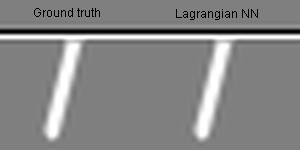

In [31]:
display.Image(filename=name, width=400)

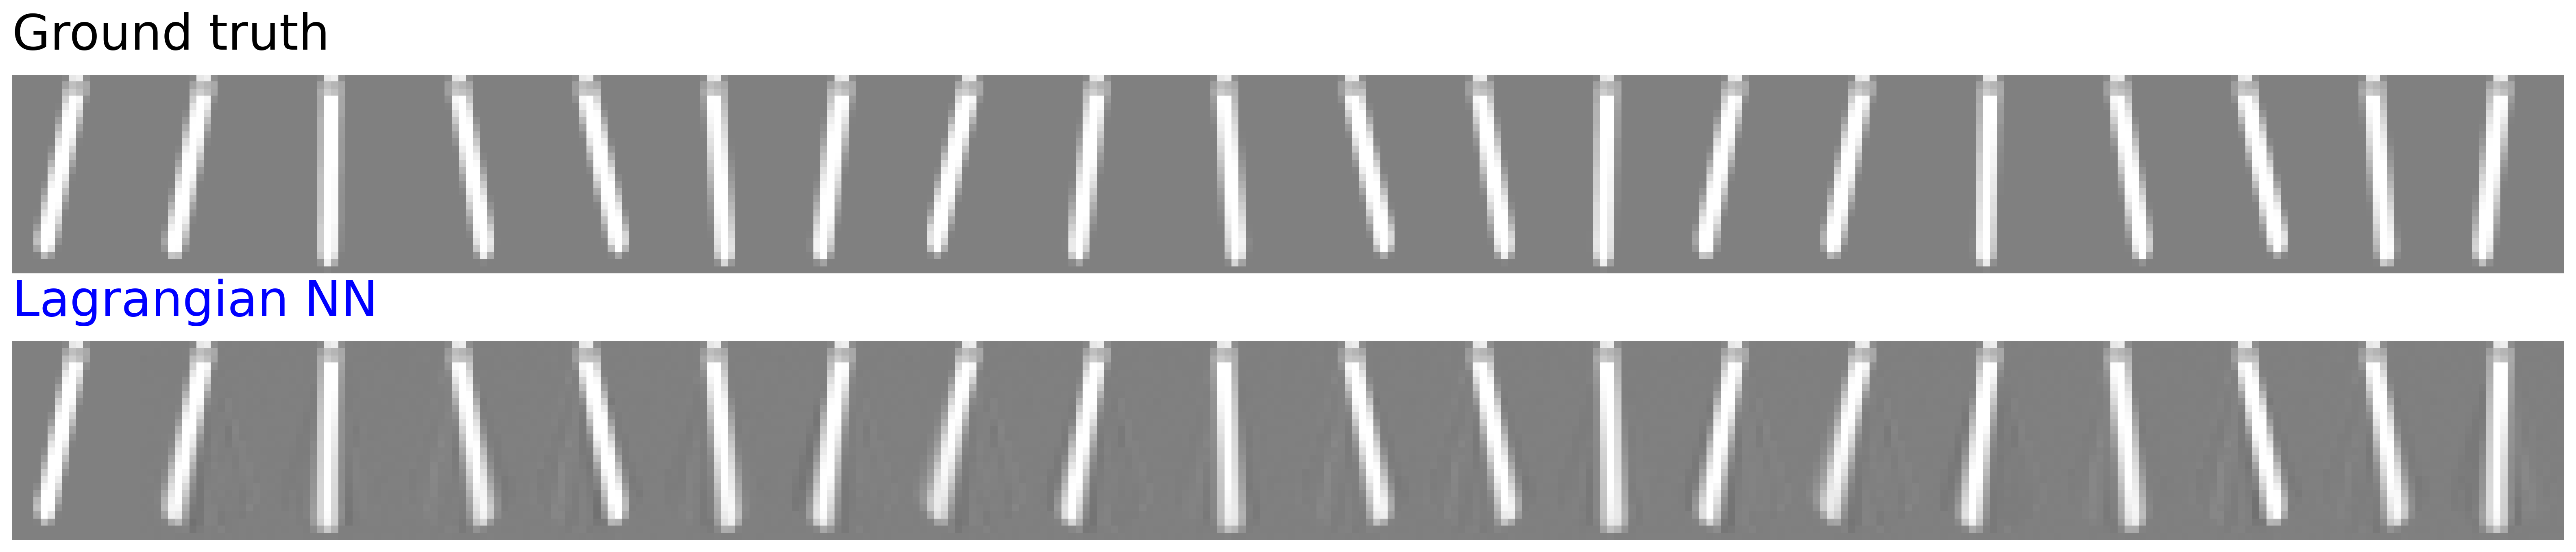

In [32]:
N = 20
tmax = 100
b = 5
k = tmax // N
true_seq = real_pixel_traj[:tmax][::k,...,b:-b].transpose(1,0,2).reshape(28,-1)
true_seq = (true_seq.clip(-.5,.5) + .5)*255

hnn_seq = _hnn_pixel_traj[:tmax][::k,...,b:-b].transpose(1,0,2).reshape(28,-1)
hnn_seq = (hnn_seq.clip(-.5,.5) + .5)*255


sy = 3
sx = .55*sy*(28.-2*b)/28

fs = 29 # font size
fig = plt.figure(figsize=[sx*N,3*sy], dpi=300)

plt.subplot(4,1,1)
plt.imshow(true_seq, cmap='gray')
plt.title('Ground truth', fontsize=fs, pad=15, loc='left')
plt.clim(0,255) ; plt.axis('off')

plt.subplot(4,1,2)
plt.imshow(hnn_seq, cmap='gray')
plt.title('Lagrangian NN', fontsize=fs, pad=15, loc='left', color='b')
plt.clim(0,255) ; plt.axis('off')


plt.tight_layout() ; plt.show()
fig.savefig('{}/pendulum-compare-static.jpeg'.format(save_dir))